# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.762732,True,6.332410
1,0.380254,True,6.319269
2,1.318211,True,6.973154
3,1.838819,True,6.618017
4,2.504549,True,6.087930
...,...,...,...
995,2.482514,True,9.913304
996,-0.462434,False,0.299569
997,1.352696,True,7.349307
998,1.378896,True,4.329894


<AxesSubplot:xlabel='v0'>

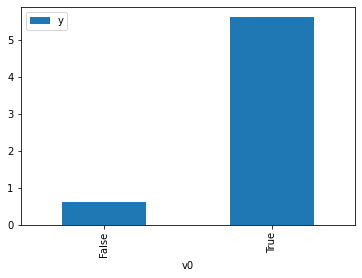

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

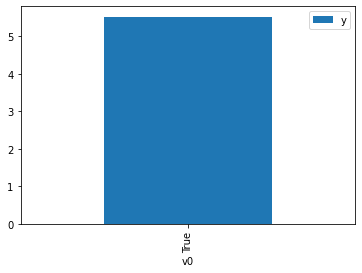

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.526686,False,1.118611,0.272814,3.665494
1,2.227615,False,1.605954,0.013424,74.490799
2,0.096453,False,0.502943,0.464697,2.151939
3,-0.706678,False,-0.394790,0.806065,1.240595
4,0.910844,False,0.543750,0.150653,6.637773
...,...,...,...,...,...
995,1.865322,False,2.068691,0.026839,37.259374
996,0.155851,False,0.275461,0.436035,2.293395
997,1.345157,False,2.066243,0.070674,14.149573
998,0.058660,False,0.094515,0.483069,2.070098


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.471884,True,5.729287,0.705479,1.417476
1,-0.002099,True,5.833732,0.487321,2.052036
2,0.845021,True,5.692377,0.832177,1.201667
3,0.101626,True,5.014653,0.537811,1.859390
4,1.535407,True,6.296723,0.950139,1.052477
...,...,...,...,...,...
995,2.822485,True,9.296195,0.995752,1.004266
996,0.223079,True,5.656650,0.595889,1.678166
997,-0.245362,True,4.769206,0.371664,2.690601
998,0.381093,True,3.849307,0.667408,1.498333


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          1.298e+04
Date:                Tue, 02 Aug 2022   Prob (F-statistic):                        0.00
Time:                        14:09:06   Log-Likelihood:                         -1405.8
No. Observations:                1000   AIC:                                      2816.
Df Residuals:                     998   BIC:                                      2825.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9264      0.037     24.916      0.000       0.853       0.999
x2             4.9949      0.055     90.205      0.000       4.886       5.104
==============================================================================
Omnibus:                        4.265   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                3.963
Skew:                          -0.103   Prob(JB):                        0.138
Kurtosis:                       2.771   Cond. No.                         2.82
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""